In [6]:
import sys
import os

# 获取当前工作目录
current_dir = os.getcwd()

# 添加项目根目录到 sys.path
project_dir = os.path.abspath(os.path.join(current_dir, './'))
# print(project_dir)
sys.path.append(project_dir)


In [7]:
import re
from typing import List
import numpy as np
import editdistance
from collections import defaultdict


# from pylatexenc.latexwalker import LatexWalker, 

from pylatexenc.latexwalker import LatexWalker
from sklearn.metrics import precision_score, recall_score, f1_score


In [8]:
def load_lns(fpath: str) -> List[str]:
    lns = []
    with open(fpath, "r") as f:
        for ln in f.readlines():
            lns.append(ln.strip())
    return lns

read test caption answer

In [9]:
test_dir = "../data/test"
test_caption_dir = os.path.join(test_dir,'caption.txt')
print(test_caption_dir)
caption_dict = {}

captions = load_lns(test_caption_dir)
max_caption_size = 0
count = 0
for cap in captions:
    img_name = cap.split()[0]
    caption_dict[img_name] = cap.split()[1:]
    if len(caption_dict[img_name]) > max_caption_size:
        max_caption_size = len(caption_dict[img_name])
    if len(caption_dict[img_name]) >= 600:
        count += 1
print(" max caption size ",max_caption_size)
print(count)
print(len(caption_dict.keys()),list(caption_dict.keys())[:5])      
print(caption_dict[list(caption_dict.keys())[0]])     

../data/test/caption.txt
 max caption size  823
7
3000 ['0054734', '0037174', '0031510', '0083407', '0037881']
['\\begin', '{aligned}', '\\boldsymbol', '{', 'K', '}', '=', '\\left', '(', '\\begin', '{array}', '{', 'c', 'c', 'c', '}', '0', '&', '0', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'p', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '\\\\', '0', '&', '0', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'm', '}', '}', '}', '\\\\', '\\mathcal', '{', 'P', '}', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'p', '}', '}', '}', '&', '\\frac', '{', '\\beta', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '{', '\\gamma', '_', '{', '\\mathrm', '{', 'f', '}', '}', '}', '&', '0', '\\end', '{array}', '\\right', ')', '\\end', '{aligned}']


In [10]:
version = 78
ckp_folder = os.path.join("lightning_logs", f"version_{version}", "checkpoints")

In [11]:
pred_dir = '../result'
pred_files = os.listdir(pred_dir)
pred_dict = {}

for pred_file in pred_files:
    with open(os.path.join(pred_dir, pred_file), 'r',encoding='utf-8') as f:
            latex = f.readlines()[1].strip()
            if latex[0] == '$' and latex[-1] == '$':
                # replace start and end '$'
                latex = latex[1:-1]
            pred_dict[pred_file.split(".")[0]] = latex.split()
        
print(len(pred_dict.keys()),list(pred_dict.keys())[:5])

print(pred_dict[list(pred_dict.keys())[0]])

2993 ['0004028', '0109606', '0035325', '0097565', '0011280']
['\\begin', '{aligned}', 'm', '_', '{', 'l', '}', '=', '\\left', '(', '\\begin', '{array}', '{', 'c', 'c', 'c', '}', '0', '.', '0', '0', '2', '5', '6', '&', '-', '0', '.', '0', '1', '0', '5', '8', '&', '0', '\\\\', '-', '0', '.', '0', '1', '0', '5', '8', '&', '0', '.', '0', '4', '5', '9', '6', '&', '0', '\\\\', '0', '&', '0', '&', '1', '\\end', '{array}', '\\right', ')', 'm', '_', '{', '\\tau', '}', '\\end', '{aligned}']


In [12]:

def calculate_edit_distance(seq1, seq2):
    """计算两个Latex序列之间的编辑距离"""
    return editdistance.eval(seq1, seq2)


def calculate_accuracy(pred_dict, true_dict):
    """计算预测结果与真实结果之间的准确率"""
    correct_count = 0
    total_count = 0
    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            if pred_seq == true_seq:
                correct_count += 1
            total_count += 1
    return correct_count / total_count if total_count > 0 else 0


def calculate_precision_recall_f1(pred_dict, true_dict):
    """计算精确度、召回率和F1分数"""
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            # 转换为二进制分类
            true_labels = [1] * len(true_seq)
            pred_labels = [1 if i < len(pred_seq) and pred_seq[i] == true_seq[i] else 0 for i in range(len(true_seq))]
            if len(pred_labels) < len(true_labels):
                pred_labels.extend([0] * (len(true_labels) - len(pred_labels)))
            all_precisions.append(precision_score(true_labels, pred_labels))
            all_recalls.append(recall_score(true_labels, pred_labels))
            all_f1s.append(f1_score(true_labels, pred_labels))

    avg_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
    avg_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
    avg_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

    return avg_precision, avg_recall, avg_f1

def is_valid_latex(seq):
    """检查LaTeX序列是否合法"""
    latex_str = ''.join(seq)
    try:
        walker = LatexWalker(latex_str)
        nodes, pos, len_ = walker.get_latex_nodes()
        return True
    except ...:
        return False

def evaluate_by_length_intervals(pred_dict, true_dict, intervals):
    """按长度区间计算准确率、编辑距离和合法性"""
    interval_results = defaultdict(lambda: {
        'correct_count': 0, 
        'total_count': 0, 
        'total_edit_distance': 0,
        'invalid_count': 0
    })

    for key in pred_dict:
        if key in true_dict:
            pred_seq = pred_dict[key]
            true_seq = true_dict[key]
            length = len(true_seq)
            for start, end in intervals:
                if start <= length < end:
                    interval_results[(start, end)]['total_count'] += 1
                    interval_results[(start, end)]['total_edit_distance'] += calculate_edit_distance(pred_seq, true_seq)
                    if pred_seq == true_seq:
                        interval_results[(start, end)]['correct_count'] += 1
                    if not is_valid_latex(pred_seq):
                        interval_results[(start, end)]['invalid_count'] += 1
                    break

    results = {}
    for interval, data in interval_results.items():
        correct_count = data['correct_count']
        total_count = data['total_count']
        total_edit_distance = data['total_edit_distance']
        invalid_count = data['invalid_count']
        accuracy = correct_count / total_count if total_count > 0 else 0
        average_edit_distance = total_edit_distance / total_count if total_count > 0 else 0
        results[interval] = {
            'accuracy': accuracy,
            'average_edit_distance': average_edit_distance,
            'total_count': total_count,
            'invalid_count': invalid_count
        }

    return results


In [13]:
# 定义长度区间
intervals = [(0, 100), (100, 200), (200, 300), (300,400),(400,600),(600,700),(700,800),(800,900),(900,1000)]
true_dict = caption_dict


In [14]:

# 计算整体准确率
overall_accuracy = calculate_accuracy(pred_dict, caption_dict)
print(f'Overall Accuracy: {overall_accuracy}')

# 计算精确度、召回率和F1分数
avg_precision, avg_recall, avg_f1 = calculate_precision_recall_f1(pred_dict, true_dict)
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')

# 计算各长度区间的指标
interval_results = evaluate_by_length_intervals(pred_dict, true_dict, intervals)

# 调试输出
print(f'Interval Results: {interval_results}')

for interval, metrics in interval_results.items():
    print(f'Interval {interval}: Accuracy = {metrics["accuracy"]}, Average Edit Distance = {metrics["average_edit_distance"]}, Total Count = {metrics["total_count"]}, Invalid Count = {metrics["invalid_count"]}')

Overall Accuracy: 0.6114266622118276
Average Precision: 1.0
Average Recall: 0.7959619334152225
Average F1 Score: 0.8282397636118085
Interval Results: {(0, 100): {'accuracy': 0.7301762114537445, 'average_edit_distance': 1.1872246696035242, 'total_count': 908, 'invalid_count': 0}, (100, 200): {'accuracy': 0.6303886925795052, 'average_edit_distance': 2.3964664310954062, 'total_count': 1415, 'invalid_count': 0}, (200, 300): {'accuracy': 0.4789272030651341, 'average_edit_distance': 7.754789272030651, 'total_count': 522, 'invalid_count': 0}, (400, 600): {'accuracy': 0.0, 'average_edit_distance': 130.22222222222223, 'total_count': 36, 'invalid_count': 0}, (300, 400): {'accuracy': 0.22321428571428573, 'average_edit_distance': 21.008928571428573, 'total_count': 112, 'invalid_count': 0}}
Interval (0, 100): Accuracy = 0.7301762114537445, Average Edit Distance = 1.1872246696035242, Total Count = 908, Invalid Count = 0
Interval (100, 200): Accuracy = 0.6303886925795052, Average Edit Distance = 2.39

分析模型分析错误的原因，图片分辨率，过长？ 还是。

标准化。
测其他的指标

  ground truth image 


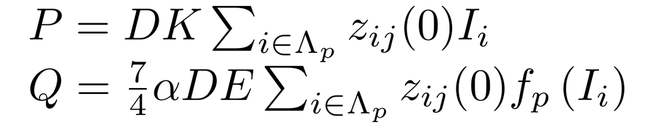

['\\begin', '{array}', '{', 'l', '}', 'P', '=', 'D', 'K', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'I', '_', '{', 'i', '}', '\\\\', 'Q', '=', '\\frac', '{', '7', '}', '{', '4', '}', '\\alpha', 'D', 'E', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'f', '_', '{', 'p', '}', '\\left', '(', 'I', '_', '{', 'i', '}', '\\right', ')', '\\end', '{array}']


<IPython.core.display.Math object>

 pred latex image
['\\begin', '{array}', '{', 'l', '}', 'P', '=', 'D', 'K', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'I', '_', '{', 'i', '}', '\\\\', 'Q', '=', '\\frac', '{', '7', '}', '{', '4', '}', '\\alpha', 'D', 'E', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'f', '_', '{', 'p', '}', '\\left', '(', 'I', '_', '{', 'i', '}', '\\right', ')', '\\end', '{array}']


<IPython.core.display.Math object>

edit distance :    0
The LaTeX sequences are equivalent.


In [15]:
import re

def extract_symbols(latex_str):
    symbols = re.findall(r'[a-zA-Z]+|\d+|\\[a-zA-Z]+', latex_str)
    return sorted(symbols)

def compare_latex_symbols(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    return symbols1 == symbols2


import random
from PIL import Image
from IPython.display import display, Math
test_img_path = os.path.join(test_dir,"img")
test_img_files = os.listdir(test_img_path)

random_img_file = random.choice(test_img_files)
random_img_path = os.path.join(test_img_path,random_img_file)

print("  ground truth image ")
display(Image.open(random_img_path))

caption_latex = caption_dict[random_img_file.split(".")[0]]

print(caption_latex)
display(Math(" ".join(caption_latex)))



print(" pred latex image")
pred_latex=  pred_dict[random_img_file.split(".")[0]]
print(pred_latex)
display(Math(" ".join(pred_latex)))



print("edit distance :   ",editdistance.eval(pred_latex,caption_latex))

if editdistance.eval(pred_latex,caption_latex)!=0:
    # print the len 

    
    print("the length of caption latex is ",len(caption_latex))

if compare_latex_symbols(" ".join(pred_latex)," ".join(caption_latex)):
    print("The LaTeX sequences are equivalent.")
else:
    print("The LaTeX sequences are not equivalent.")    


In [16]:
# import sympy as sp
# from sympy.parsing.latex import parse_latex

# # 提供的LaTeX表达式列表
# latex_expr1_list = ['\\begin', '{array}', '{', 'l', '}', 'p', '(', '\\phi', '\\xi', ')', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '-', '1', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '}', '}', '\\\\', '=', '-', 'q', '(', '\\psi', '\\xi', ')', '\\psi', '_', '{', 'x', '}', '^', '{', 'q', '-', '1', '}', '\\cdot', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '}', '\\\\', '=', 'p', 'q', '(', '\\phi', '\\psi', ')', '\\phi', '_', '{', 'x', '^', '{', 'p', '-', '1', '}', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '-', '1', '}', '}', '\\end', '{array}']

# latex_expr2_list = ['\\begin', '{aligned}', '&', 'p', '(', '\\phi', '\\xi', ')', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '-', '1', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '}', '}', '\\\\', '&', '=', '-', 'q', '(', '\\psi', '\\xi', ')', '\\psi', '_', '{', 'x', '}', '^', '{', 'q', '-', '1', '}', '\\cdot', '\\phi', '_', '{', 'x', '}', '^', '{', 'p', '}', '\\\\', '&', '=', 'p', 'q', '(', '\\phi', '\\psi', ')', '\\phi', '_', '{', 'x', '^', '{', 'p', '-', '1', '}', '}', '\\cdot', '\\psi', '_', '{', 'x', '^', '{', 'q', '-', '1', '}', '}', '\\end', '{aligned}']

# # 移除LaTeX环境标记函数
# def remove_latex_env(latex_list):
#     ignore_tokens = {'\\begin', '\\end', '{array}', '{aligned}', '&', '{', '}', '\\\\'}
#     return ''.join([token for token in latex_list if token not in ignore_tokens])

# # 移除LaTeX环境标记
# latex_expr1_cleaned = remove_latex_env(latex_expr1_list)
# latex_expr2_cleaned = remove_latex_env(latex_expr2_list)

# # 打印转换后的字符串
# print("LaTeX Expr 1:", latex_expr1_cleaned)
# print("LaTeX Expr 2:", latex_expr2_cleaned)

# # 尝试将清理后的表达式转换为SymPy表达式
# try:
#     expr1 = parse_latex(latex_expr1_cleaned)
#     expr2 = parse_latex(latex_expr2_cleaned)
# except Exception as e:
#     print("Error parsing LaTeX expressions:", e)
#     expr1 = None
#     expr2 = None

# # 如果解析成功，则进行比较
# if expr1 and expr2:
#     # 方法1: 数学简化和标准化
#     simplified_expr1 = sp.simplify(expr1)
#     simplified_expr2 = sp.simplify(expr2)
#     print("Simplified expressions are equal:", simplified_expr1 == simplified_expr2)

#     # 方法2: 符号比较
#     expanded_expr1 = sp.expand(expr1)
#     expanded_expr2 = sp.expand(expr2)
#     print("Expanded expressions are equal:", expanded_expr1 == expanded_expr2)

#     # 方法3: 结构化比较
#     tree_expr1 = sp.srepr(expr1)
#     tree_expr2 = sp.srepr(expr2)
#     print("Expression trees are equal:", tree_expr1 == tree_expr2)

#     # 方法5: 符号推理和代数恒等式
#     simplified_expr1 = sp.simplify(expr1)
#     simplified_expr2 = sp.simplify(expr2)
#     print("Symbolically simplified expressions are equal:", simplified_expr1 == simplified_expr2)

#     # 方法6: LaTeX 语法和解析工具
#     # 使用 SymPy 解析 LaTeX 表达式并进行比较
#     latex_expr1_sympy = sp.sympify(sp.latex(expr1))
#     latex_expr2_sympy = sp.sympify(sp.latex(expr2))
#     print("Parsed LaTeX expressions are equal:", latex_expr1_sympy == latex_expr2_sympy)
# else:
#     print("Parsing failed, unable to compare expressions.")

In [17]:
import os
import re
import random
from PIL import Image
from IPython.display import display, Math
import difflib
import editdistance

# 提取符号的函数
def extract_symbols(latex_str):
    symbols = re.findall(r'[a-zA-Z]+|\d+|\\[a-zA-Z]+|[^a-zA-Z\d\s\\]', latex_str)
    return symbols

# 生成编辑路径并显示具体的编辑操作
def generate_edit_path(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    
    matcher = difflib.SequenceMatcher(None, symbols1, symbols2)
    edit_path = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i in range(i1, i2):
                edit_path.append(('match', symbols1[i], symbols2[j1 + (i - i1)]))
        elif tag == 'replace':
            for i in range(i1, i2):
                edit_path.append(('replace', symbols1[i], symbols2[j1 + (i - i1)]))
        elif tag == 'delete':
            for i in range(i1, i2):
                edit_path.append(('delete', symbols1[i], ''))
        elif tag == 'insert':
            for j in range(j1, j2):
                edit_path.append(('insert', '', symbols2[j]))
    
    return edit_path

# 打印编辑路径
def print_edit_path(edit_path):
    for action, sym1, sym2 in edit_path:
        # if action == 'match':
        #     print(f"Match: {sym1} == {sym2}")
        if action == 'replace':
            print(f"Replace: {sym1} -> {sym2}")
        elif action == 'delete':
            print(f"Delete: {sym1}")
        elif action == 'insert':
            print(f"Insert: {sym2}")

# 比较符号是否等价
def compare_latex_symbols(latex1, latex2):
    symbols1 = extract_symbols(latex1)
    symbols2 = extract_symbols(latex2)
    return sorted(symbols1) == sorted(symbols2)


# 主函数
def analyze_latex_comparison(test_dir, caption_dict, pred_dict, length_range, idx):
    # 过滤符合长度范围的LaTeX序列并计算预测错误的序列
    error_keys = []
    for key in caption_dict:
        if length_range[0] <= len(caption_dict[key]) <= length_range[1]:
            caption_latex = caption_dict[key]
            pred_latex = pred_dict.get(key, [])
            edit_dist = editdistance.eval(pred_latex, caption_latex)
            if edit_dist != 0:
                error_keys.append(key)
    
    if idx >= len(error_keys):
        print("Index out of range")
        return
    print(f"Current idx: {idx + 1} out of {len(error_keys)} total errors")
    selected_key = error_keys[idx]
    random_img_file = selected_key + ".bmp"
    random_img_path = os.path.join(test_dir, "img", random_img_file)

    print("Ground truth image:")
    display(Image.open(random_img_path))

    caption_latex = caption_dict[selected_key]
    print("Caption LaTeX:")
    display(Math(" ".join(caption_latex)))

    pred_latex = pred_dict[selected_key]
    print("Predicted LaTeX:")
    display(Math(" ".join(pred_latex)))

    # 计算编辑距离
    edit_dist = editdistance.eval(pred_latex, caption_latex)
    print("Edit distance:", edit_dist)

    # 生成并显示编辑路径
    if edit_dist != 0:
        edit_path = generate_edit_path(" ".join(caption_latex), " ".join(pred_latex))
        
        print("Length of caption LaTeX:", len(caption_latex))
        print("Length of predicted LaTeX:", len(pred_latex))
        
        print("Edit Path:")
        print_edit_path(edit_path)

    # 比较符号是否等价
    if compare_latex_symbols(" ".join(pred_latex), " ".join(caption_latex)):
        print("The LaTeX sequences are equivalent.")
    else:
        print("The LaTeX sequences are not equivalent.")

In [18]:
# 示例调用
# test_dir = "path/to/your/test_directory"  # 修改为你的测试目录路径
# caption_dict = {"example_key": ["\\phi", "=", "a", "+", "b"]}  # 修改为你的caption字典
# pred_dict = {"example_key": ["\\phi", "=", "a", "-", "b"]}  # 修改为你的预测字典
length_range = (0,100)  # 修改为你需要的长度范围
idx = 0  # 选择第几个预测错误的序列



/home/liyu/Project/icpr/notebooks
../data/test
Current idx: 1 out of 250 total errors
Ground truth image:


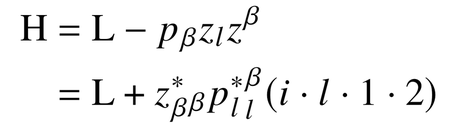

Caption LaTeX:


<IPython.core.display.Math object>

Predicted LaTeX:


<IPython.core.display.Math object>

Edit distance: 16
Length of caption LaTeX: 81
Length of predicted LaTeX: 67
Edit Path:
Delete: {
Delete: }
Delete: _
Delete: {
Delete: \beta
Delete: }
Insert: l
Delete: }
Delete: {
Delete: }
Delete: _
Delete: {
Delete: l
Delete: }
Delete: ^
Delete: {
The LaTeX sequences are not equivalent.


In [19]:
print(os.getcwd())
print(test_dir)
analyze_latex_comparison(test_dir, caption_dict, pred_dict, length_range, idx)
# print("idx = ",idx)
idx += 1

In [20]:
# 统计指定长度范围内包含特定字符串的预测错误情况
def analyze_errors_with_substrings(test_dir, caption_dict, pred_dict, length_range, substrings):
    error_count = 0
    total_count = 0
    contain_count = 0
    
    for key in caption_dict:
        caption_latex = caption_dict[key]
        if length_range[0] <= len(caption_latex) <= length_range[1]:
            total_count += 1
            contains_substring = any(sub in " ".join(caption_latex) for sub in substrings)
            if contains_substring:
                contain_count += 1
                pred_latex = pred_dict.get(key, [])
                edit_dist = editdistance.eval(pred_latex, caption_latex)
                if edit_dist != 0:
                    error_count += 1
    print(" ",length_range)
    print(f"Total sequences in range: {total_count}")
    print(f"total {contain_count} contain these string ")
    print(f"Total sequences with errors containing specified substrings: {error_count}")
    print(f"Error rate: {error_count / contain_count * 100:.2f}%")
    
# substrings = ["\\mathrm","\\mathbf","\\boldsymbol"]
# substrings = ["\\mathbf"]

# analyze_errors_with_substrings(test_dir, caption_dict, pred_dict, (0,100), substrings)

In [21]:
substrings = ["\\mathrm","\\mathbf","\\boldsymbol"]
for i in range(0,400,100):
    for s in substrings:
        analyze_errors_with_substrings(test_dir, caption_dict, pred_dict, (i,i+100), [s])

  (0, 100)
Total sequences in range: 932
total 231 contain these string 
Total sequences with errors containing specified substrings: 59
Error rate: 25.54%
  (0, 100)
Total sequences in range: 932
total 55 contain these string 
Total sequences with errors containing specified substrings: 24
Error rate: 43.64%
  (0, 100)
Total sequences in range: 932
total 27 contain these string 
Total sequences with errors containing specified substrings: 17
Error rate: 62.96%
  (100, 200)
Total sequences in range: 1425
total 578 contain these string 
Total sequences with errors containing specified substrings: 222
Error rate: 38.41%
  (100, 200)
Total sequences in range: 1425
total 123 contain these string 
Total sequences with errors containing specified substrings: 70
Error rate: 56.91%
  (100, 200)
Total sequences in range: 1425
total 88 contain these string 
Total sequences with errors containing specified substrings: 57
Error rate: 64.77%
  (200, 300)
Total sequences in range: 523
total 248 cont

In [29]:
from PIL import Image, UnidentifiedImageError
from IPython.display import display, Math, clear_output
import difflib
import io
from contextlib import redirect_stdout

from IPython.display import Math, display_latex, clear_output
import IPython

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# 检查LaTeX序列是否合法
from IPython.display import Math, display
import re

from IPython.display import display, Javascript

def is_valid_latex(latex_sequence):
    # 使用 JavaScript 进行 LaTeX 渲染并捕捉错误
    display(Javascript(f"""
    (function() {{
        var valid = true;
        try {{
            var katex = require('katex');
            var html = katex.renderToString("{latex_sequence.replace('\\', '\\\\')}");
        }} catch (e) {{
            valid = false;
        }}
        if (valid) {{
            console.log("Valid LaTeX");
        }} else {{
            console.log("Invalid LaTeX");
        }}
    }})();
    """))


# 统计指定长度范围内不合法的预测序列
def analyze_invalid_latex_sequences(caption_dict, pred_dict, length_range):
    invalid_count = 0
    total_count = 0

    for key in caption_dict:
        caption_latex = caption_dict[key]
        if length_range[0] <= len(caption_latex) <= length_range[1]:
            total_count += 1
            pred_latex = pred_dict.get(key, [])
            if not is_valid_latex(pred_latex):
                invalid_count += 1

    print(" length ",  length_range)
    print(f"Total sequences in range: {total_count}")
    print(f"Total invalid predicted sequences: {invalid_count}")

analyze_invalid_latex_sequences(caption_dict, pred_dict, (0, 400))

SyntaxError: f-string expression part cannot include a backslash (4056226493.py, line 37)

测试latex序列能否被渲染

In [23]:
print((pred_latex))

['\\begin', '{array}', '{', 'l', '}', 'P', '=', 'D', 'K', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'I', '_', '{', 'i', '}', '\\\\', 'Q', '=', '\\frac', '{', '7', '}', '{', '4', '}', '\\alpha', 'D', 'E', '\\sum', '_', '{', 'i', '\\in', '\\Lambda', '_', '{', 'p', '}', '}', 'z', '_', '{', 'i', 'j', '}', '(', '0', ')', 'f', '_', '{', 'p', '}', '\\left', '(', 'I', '_', '{', 'i', '}', '\\right', ')', '\\end', '{array}']


In [24]:
# 

In [70]:
from IPython.display import Math, display, HTML
import re

def render_latex(latex_sequence):
    try:
        rendered = Math(latex_sequence)._repr_latex_()

        (display(Math(latex_sequence)).)
    except Exception as e:
        print(f"Unexpected Error: {e}")

# 示例 LaTeX 表达式
valid_latex = r"a + b = c"
invalid_latex = r"a + b \left {"

# 渲染合法的 LaTeX 表达式
render_latex(valid_latex)

# 尝试渲染不合法的 LaTeX 表达式，并捕捉错误
render_latex(invalid_latex)

<IPython.core.display.Math object>

Unexpected Error: 'NoneType' object has no attribute '_repr_html_'


<IPython.core.display.Math object>

Unexpected Error: 'NoneType' object has no attribute '_repr_html_'


Is the LaTeX code valid? True


FileNotFoundError: [Errno 2] No such file or directory: 'pdflatex': 'pdflatex'